# Imports

In [19]:
# import sys, os

# from math import log10
# from numpy import array, pi

import pandas as pd
import numpy as np
# from numpy import concatenate
# from bisect import bisect_left
# import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from hist import Hist
import hist

from sklearn.model_selection import train_test_split, StratifiedKFold # cross_val_score, KFold,
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score # zero_one_loss, roc_auc_score, auc
# from sklearn.base import clone
# algorithms:
from sklearn.tree import DecisionTreeClassifier#, export_graphviz, plot_tree, export_text # Available in later versions
#import graphviz
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from joblib import dump, load

# Setup plotting

In [20]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'serif','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

# Parameters

In [21]:
SE_size = 47.07
ana_thresh_e = 3.5

# Get data

In [22]:
df1 = pd.read_csv('data/tritium_ML_data.csv')
df2 = pd.read_csv('data/bg_sr1_vetoes.csv')
df3 = pd.read_csv('data/bg_sr1_vetoes_gassplit.csv')

df = pd.concat([df1,df3], ignore_index=True)
df = df.drop('Unnamed: 0', axis = 1)
df.head()


,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,6930.0,2,tritium,320.0,570.0,680.0,780.0,740.0,380.0
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,7150.0,2,tritium,360.0,770.0,850.0,740.0,690.0,430.0
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,7000.0,2,tritium,270.0,480.0,580.0,570.0,510.0,300.0
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,5800.0,2,tritium,270.0,550.0,640.0,620.0,580.0,400.0
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,8690.0,2,tritium,440.0,770.0,930.0,790.0,620.0,330.0


# Re-weight data

In [23]:
electron_axis = hist.axis.Regular(100,5,500,name="electrons",
                           label="Extracted electrons",flow=False)

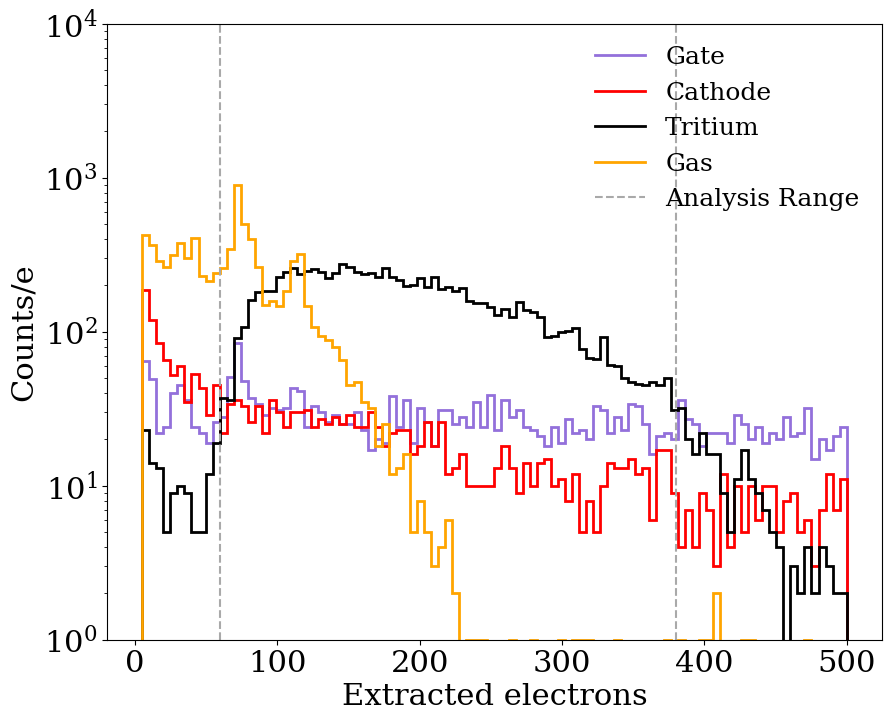

In [24]:
gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
gate_hist.fill(df.ext_elec[gate_cut])

gas_hist = Hist(electron_axis)
gas_cut = df.type == "gas"
gas_hist.fill(df.ext_elec[gas_cut])

cath_hist = Hist(electron_axis)
cath_cut = df.type == "cathode"
cath_hist.fill(df.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df.type == "tritium"
trit_hist.fill(df.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
gas_hist.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[1,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [25]:
# implementing thresholds
thresh_cut = (60 < df.ext_elec) & (df.ext_elec < 380)
df_cut_gas = df[thresh_cut].reset_index().drop('index', axis = 1)

In [26]:
# handscanning the weird cathode data bumps 
S2_gate_cut = (100 < df.ext_elec) & (df.ext_elec < 140) 
for ii in range(1,11):
    print('%s\t%s'%(df.runID[S2_gate_cut&gate_cut].to_numpy()[ii], df.eventID[S2_gate_cut&gate_cut].to_numpy()[ii]))
    


6975	17189
6993	33265
6986	30110
7051	83963
7022	141385
6988	3398
7047	3839
7058	18772
7016	50349
6967	66574


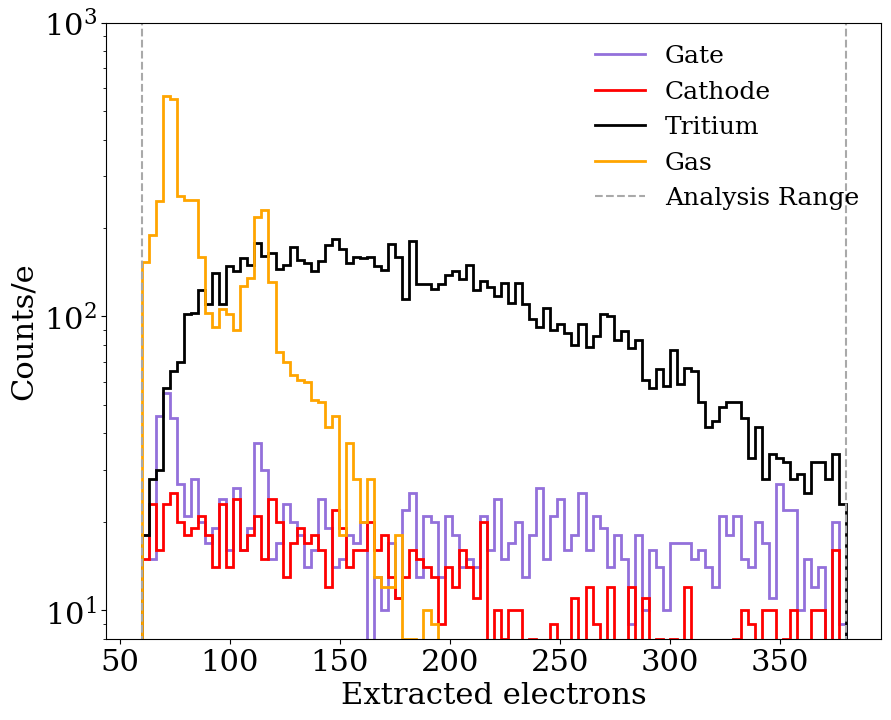

In [27]:
# histogram with threshold data
electron_axis2 = hist.axis.Regular(100,60,380,name="electrons",
                           label="Extracted electrons",flow=False)

gate_hist2 = Hist(electron_axis2)
gate_cut2 = df_cut_gas.type == "gate"
gate_hist2.fill(df_cut_gas.ext_elec[gate_cut2])

cath_hist2 = Hist(electron_axis2)
cath_cut2 = df_cut_gas.type == "cathode"
cath_hist2.fill(df_cut_gas.ext_elec[cath_cut2])

trit_hist2 = Hist(electron_axis2)
trit_cut2 = df_cut_gas.type == "tritium"
trit_hist2.fill(df_cut_gas.ext_elec[trit_cut2])

gas_hist2 = Hist(electron_axis2)
gas_cut2 = df_cut_gas.type == "gas"
gas_hist2.fill(df_cut_gas.ext_elec[gas_cut2])


fig, ax = plt.subplots(figsize=(10, 8))
gate_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
gas_hist2.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[8,1000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [28]:
#weighting data w/o gas events 
weight_list = []

for ii in range(df_cut_gas.shape[0]):
    if df_cut_gas.type[ii] == 'gate':
        index = np.searchsorted(gate_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = gate_hist2[index]
    elif df_cut_gas.type[ii] == 'cathode':
        index = np.searchsorted(cath_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = cath_hist2[index]
    elif df_cut_gas.type[ii] == 'tritium':
        index = np.searchsorted(trit_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = trit_hist2[index]     
    weight_list.append(1/bin_counts)
        
df_cut_gas['weights_no_gas'] = weight_list

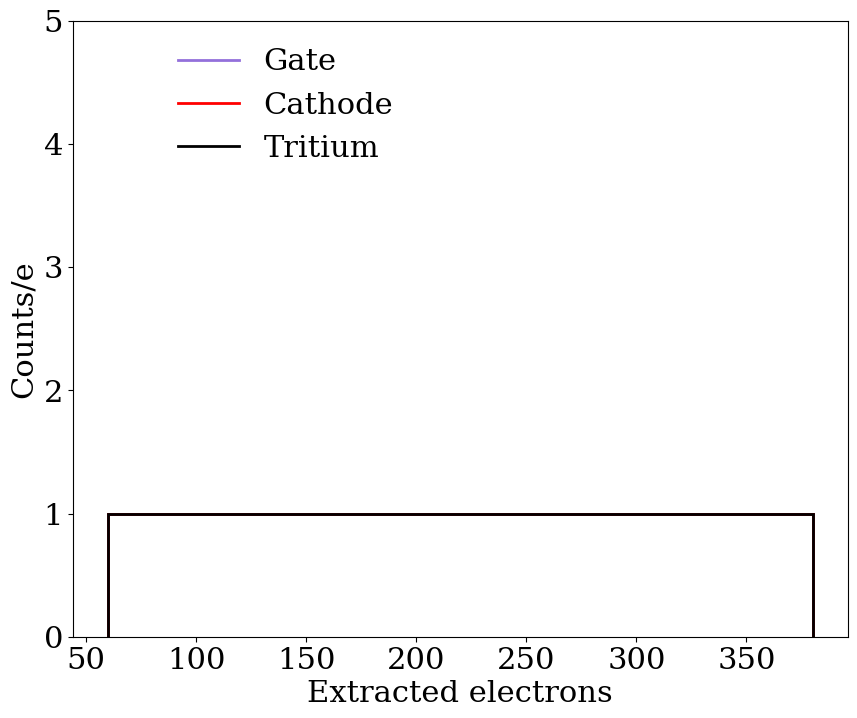

In [29]:
norm_gate_hist = Hist(electron_axis2)
norm_gate_hist.fill(df_cut_gas.ext_elec[gate_cut2],weight = df_cut_gas.weights_no_gas[gate_cut2])

norm_cath_hist = Hist(electron_axis2)
norm_cath_hist.fill(df_cut_gas.ext_elec[cath_cut2],weight = df_cut_gas.weights_no_gas[cath_cut2])

norm_trit_hist = Hist(electron_axis2)
norm_trit_hist.fill(df_cut_gas.ext_elec[trit_cut2],weight = df_cut_gas.weights_no_gas[trit_cut2])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,5])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

# Machine learning

### Prepare data for machine learning

- Note that the signal types are labelled in the 'label' field as follows:
    - Cathode - 0
    - Gate - 1
    - Tritium - 2
    - Gas - 3 (removed from ML training dataset)

In [30]:
df_cut_gas.loc[df_cut_gas["type"] == "tritium", "label"] = 1
df_cut_gas.loc[df_cut_gas["type"] == "gate", "label"] = 0
df_cut = df_cut_gas[df_cut_gas["type"] != 'gas'] #removing gas events


In [31]:
# ML for only pulse width 

features = ['S2_width', 'ext_elec']

X2 = df_cut[features]
Y2 = df_cut['label']
T2 = df_cut['type']
W2 = df_cut['weights_no_gas'] # - should this be the weight calculated above? 
A2 = df_cut['area']
R2 = df_cut['r']
X2_raw = df_cut['x']
Y2_raw = df_cut['y']
X2_train_unscaled, X2_test_unscaled, \
Y2_train, Y2_test, \
A2_train, A2_test, \
T2_train, T2_test, \
W2_train, W2_test, \
R2_train, R2_test, \
X2_raw_train, X2_raw_test, \
Y2_raw_train, Y2_raw_test = \
train_test_split(X2, Y2, A2, T2, W2, R2, X2_raw, Y2_raw, random_state=0)

In [32]:
scaler = MinMaxScaler()
X2_train = scaler.fit_transform(X2_train_unscaled.astype('float64'))
X2_test = scaler.transform(X2_test_unscaled.astype('float64'))
E2_test = A2_test/SE_size

In [47]:
DTC2 = DecisionTreeClassifier(max_depth=2,min_samples_split=2)
ABC2 = AdaBoostClassifier(base_estimator=DTC2,n_estimators=100,algorithm = 'SAMME')
width_only_model = ABC2.fit(X2_train, Y2_train.values.ravel()
                ,sample_weight=W2_train.values.ravel().astype('float64'))

Y2_score = width_only_model.decision_function(X2_test)
print(Y2_score)

width_only_model.score(X2_train, Y2_train, sample_weight=W2_train.astype('float64')), \
width_only_model.score(X2_test, Y2_test, sample_weight=W2_test.astype('float64')) 

/Users/ruadhri/opt/anaconda3/envs/spyder-env/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[ 0.18376074  0.16517558  0.29154415 ...  0.22410087  0.05650041
 -0.69288064]


(0.7928710742089133, 0.7695774193152575)

# Cross-Validation using RandomizedSearchCV

In [34]:
base_estimator = DecisionTreeClassifier()
adaboost = AdaBoostClassifier(estimator=base_estimator)

# Define parameter grid
# using the base_estimator syntax to indicate parameters for the decisiontree estimator
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.1, 0.5, 1, 1.5, 2],#[0.01, 0.1, 1],
    #'algorithm': ['SAMME', 'SAMME.R'], # automatically SAMME.R
    'estimator__max_depth': [1, 2, 3, 5, 10, 15, 20, 25],
    'estimator__min_samples_split': [2, 4, 6, 10, 15, 20],
    'estimator__min_samples_leaf': [1, 2, 3, 4, 5],
    #'estimator__max_features': ['auto', 'sqrt', 'log2', None], # automatically None
    # 'estimator__max_leaf_nodes': [None, 5, 10, 20] # automatically None
}

# Create RandomizedSearchCV instance
# choosing a large number of parameters and a large number of iterations also
random_search = RandomizedSearchCV(adaboost, 
                                   param_distributions=param_grid,
                                     n_iter=100, 
                                     cv=StratifiedKFold(n_splits=10, 
                                                        shuffle=True, 
                                                        random_state=42)
                                                        )#, scoring='roc_auc')

# Fit to data
random_search.fit(X2_train, Y2_train.values.ravel(),
                  sample_weight=W2_train.values.ravel().astype('float64'))

# Best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [48]:
print('Best Params')
print(best_params)
print()
print('best model')
print(best_model)
print()
print('best score')
print(random_search.best_score_)
print()

# redefine model and Y_score to be the model with the best params, for comparison
model = best_model
Y2_score = model.decision_function(X2_test)
print(Y2_score)

print()
print('Feature Importances\n')
for i in range(len(features)):
    print(str(features[i]) + ' - ' + str(model.feature_importances_[i]))

# save model
dump(model, 'optimised_singleclass_BDT.joblib')

Best Params
{'n_estimators': 200, 'learning_rate': 2, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 4, 'estimator__max_depth': 25}

best model
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=25,
                                                    min_samples_leaf=4),
                   learning_rate=2, n_estimators=200)

best score
0.8721780867607514

[ 21.13624103  35.83563423  34.77458666 ...  35.37683882  35.9643584
 -27.62393535]

Feature Importances

S2_width - 0.751415717902313
ext_elec - 0.2485842820976879


['optimised_singleclass_BDT.joblib']

# Understanding machine learning

In [36]:
bin_labels = ['Total', r'60 < $n_e$ < 100', r'100 < $n_e$ < 140', r'140 < $n_e$ < 180', r'180 < $n_e$ < 220',
              r'220 < $n_e$ < 240', r'240 < $n_e$ < 280', r'280 < $n_e$ < 320', r'320 < $n_e$ < 380']
bin_colors = ["black", "purple", "darkblue", "cyan", "green", "gold", "orange", "red", "hotpink"  ]

In [37]:
test_error_list = []
start = 60
tritium_cut = T2_test == 'tritium'
for i in range(8):
    test_error = [ ]
    bin_cut = (start < E2_test) & (E2_test < start + 40)
    start += 40
    for test_predict in model.staged_predict(X2_test[bin_cut & tritium_cut]):
        test_error.append(1.-accuracy_score(test_predict,Y2_test[bin_cut & tritium_cut],sample_weight=W2_test[bin_cut & tritium_cut].ravel().astype('float64')))
    test_error_list.append(test_error)

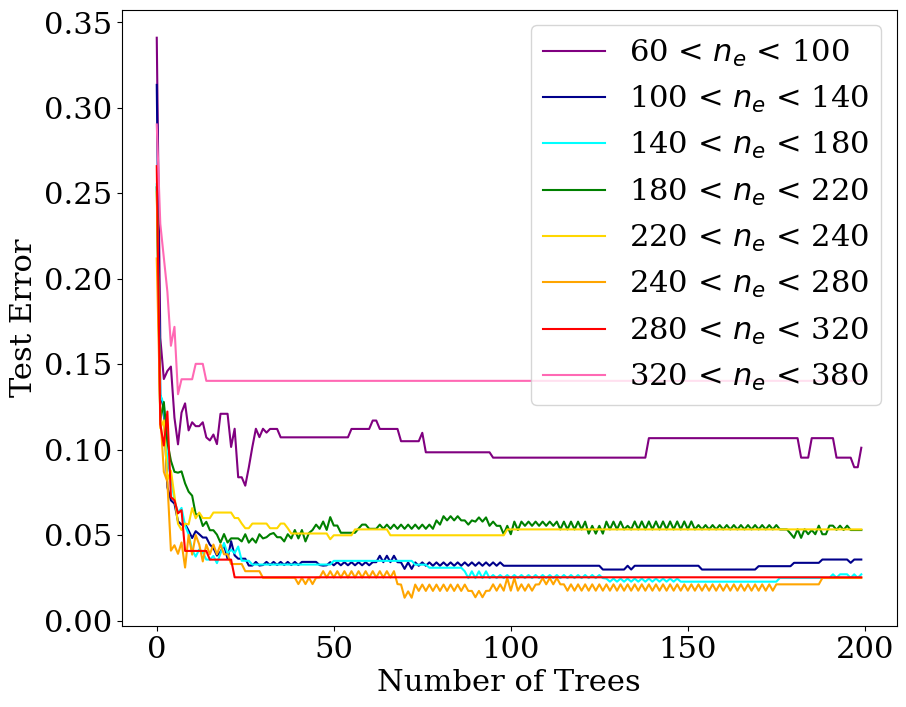

In [38]:
#test error - these are very weird 
for i in range(8):
    #ax.legend(fontsize = 12)
    plt.xlabel('Number of Trees')
    plt.ylabel('Test Error')
    plt.plot(test_error_list[i], color = bin_colors[i+1], label=bin_labels[i+1])
    plt.legend()
    #plt.show()



# Bins for ROC curves 

- Full range (60-380)
- For now will do evenly spaced bins i.e:
60-100
100-140
140-180
180-220
220-260
260-300
300-340
340-380


In [39]:
ROC_params_list2 = []
start = 60
Y2_score = model.decision_function(X2_test)

for i in range(8): 
    bin_cut = (start < E2_test) & (E2_test < start + 40)
    start += 40
    FPR, TPR, TH = roc_curve(Y2_test[bin_cut],Y2_score[bin_cut],sample_weight = W2_test[bin_cut], pos_label = 1)
    ROC_params_list2.append([FPR, TPR, TH])

In [41]:
# Finding max efficiency ratio 
def eff_calc(e_s, e_b):
        return np.divide(e_s, np.sqrt(e_b), out=np.zeros_like(e_s), where=e_b!=0)
maxes = []
ratios_list = []
for i in range(8):
    ratios = eff_calc(ROC_params_list2[i][1], ROC_params_list2[i][0])
    ratios_list.append(ratios)
    ind = np.where(ratios == np.max(ratios))
    maxes.append([ROC_params_list2[i][1][ind], ROC_params_list2[i][0][ind]])

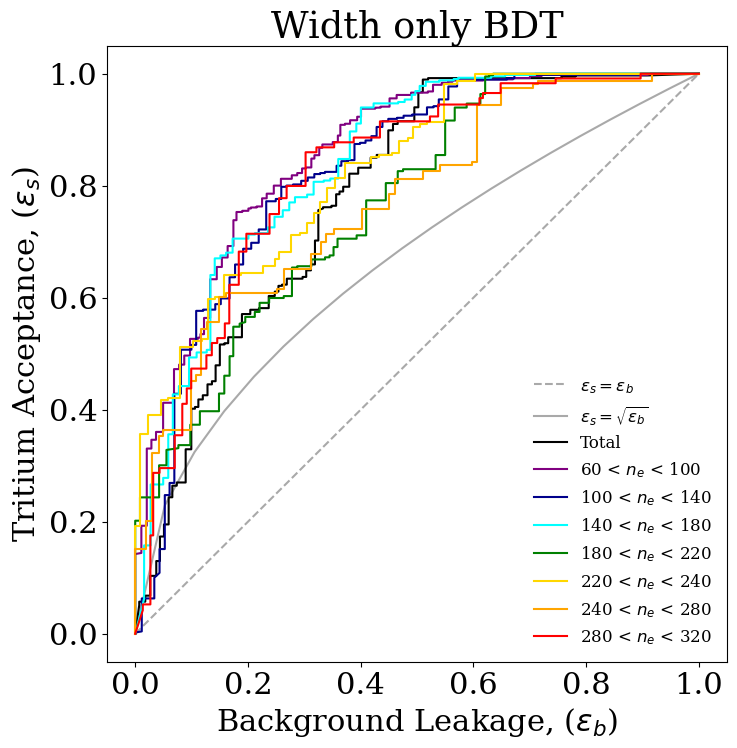

In [42]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_list2[i][0], ROC_params_list2[i][1], label = bin_labels[i], color = bin_colors[i])
    #ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Background Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.set_title('Width only BDT')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)


In [43]:
# splitting into gate and cathode
ROC_params_gate2 = []
ROC_params_cath2 = []
start = 60
for i in range(8): 
    bin_cut = (start < E2_test) & (E2_test < start + 40)
    start += 40
    gate_cut_ =  T2_test != 'cathode' 
    FPR, TPR, TH = roc_curve(Y2_test[bin_cut&gate_cut_],Y2_score[bin_cut&gate_cut_],sample_weight = W2_test[bin_cut&gate_cut_], pos_label = 1)
    ROC_params_gate2.append([FPR, TPR, TH])
    cath_cut_ =  T2_test != 'gate' 
    FPR, TPR, TH = roc_curve(Y2_test[bin_cut&cath_cut_],Y2_score[bin_cut&cath_cut_],sample_weight = W2_test[bin_cut&cath_cut_], pos_label = 1)
    ROC_params_cath2.append([FPR, TPR, TH])


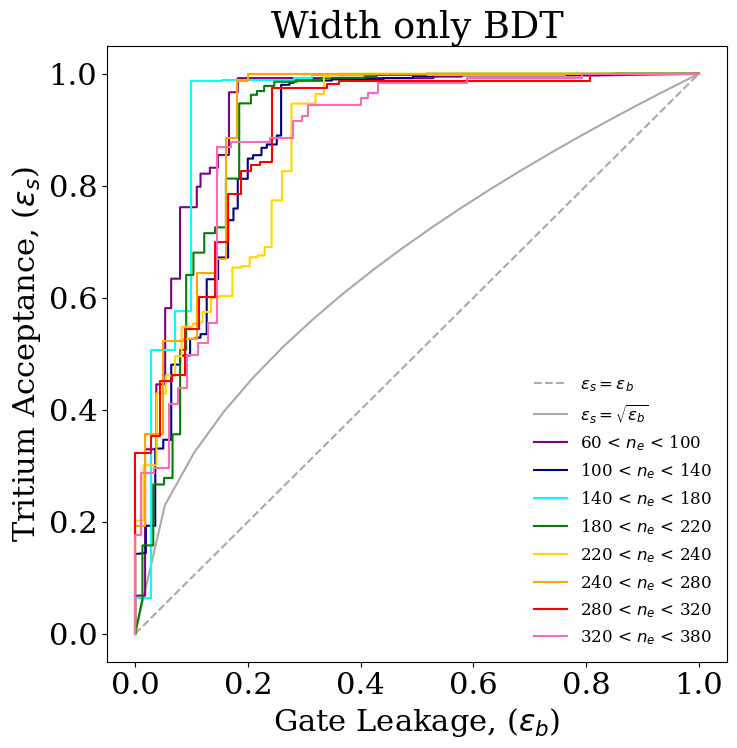

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_gate2[i][0], ROC_params_gate2[i][1], label = bin_labels[i+1], color = bin_colors[i+1])
    #ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Gate Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.set_title('Width only BDT')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

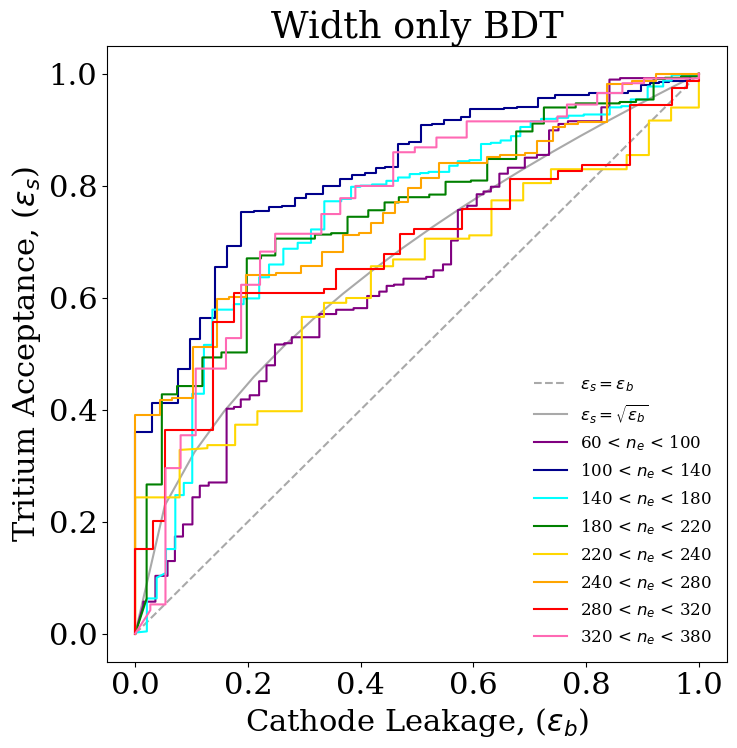

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_cath2[i][0], ROC_params_cath2[i][1], label = bin_labels[i+1], color = bin_colors[i+1])
    #ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Cathode Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.set_title('Width only BDT')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

In [46]:
model.feature_importances_

array([0.75141572, 0.24858428])

#TODO

- Histogram with gas events 
- BDT without gas events 
    - Same ROC curves for this BDT as before
- Histograms of params against S2 size
    - Split into classes
- 1D histograms of params 
- 1D histogram of y score for each bin, sep into gate, cath, trit
    - plot line to keep 80% of trit events (disc_score_cut)
    - apply cut & normalise with total events to get data point
    - width from width of bin
    - yerror from poisson error - sqrt(num)/demon
- Make for width only BDT also
- Optimise hyperparams 
- Clean up notebook & make final plots 


# Notes 
- Importances didn't make sense visually from dtxx_xx scatter plots so ran BDTs with only gate and only cathode
    - Cathode heavily favouring the dt50_25 which explains the skew 
- Ran with max_depth set to 1 which fixed the test error? Also made the importances a bit more even 